### **ME 599D Data-Driven Modeling**
Bingwen Hu, Dau Cheng \
Group Contribution: The project is finished together, and the work is equally distributed between the 2 of us.
### **Football Match Probability Prediction**
<img src="https://activeforlife.com/img/large-webp/2018/07/soccer-ball-2121x1414.jpg" alt="drawing" width="400"/> \

Link to the data on Google drive: https://drive.google.com/drive/folders/1ZCW5d-dzu3jMrfl-vwh89Zd0fqXWYK8y?usp=sharing

### **Context and Datasets**
The dataset and original idea of this project is retrieved from a soccer prediction competition on kaggle presented by Octosport and Sportmonks. The competition is about predicting the probabilities of more than 150,000 match outcomes from 2019 to 2021 using the recent sequence of 10 matches of the teams.
And our goal is to apply machine learning models on the given dataset and try to compare the result with the bookmakers odds. \

### **Approach**
We plan to use Python as our main programming language with Pandas, numpy and matplotlib package for data wrangling and visualization. Scikit-Learn、 Tensorflow(LSTM model) are leveraged for data training, prediction and validation. Concretely, the scikit-Learn is utilized to scale data, implement cross validation and also compute log-loss to validate the prediction. Tensorflow is a platform to implement our machine learning models, we eventually chose a Long short-term memory model, the LSTM model to train the datasets.







#### 1. Import modules and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import datetime as dt
import os
import random
from google.colab import drive
from pathlib import Path
from IPython.display import Image

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss

import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers

In [2]:
# Mount google drive
drive.mount('/content/drive')	
os.chdir('/content/drive/MyDrive/UW/ME599D')
PATH = Path("/content/drive/MyDrive/UW/ME599D/data")

Mounted at /content/drive


**GPU** \
In this notebook, we use the hardware accelerator GPU provided by Google colab to save our time. \
By using the GPU, we can significantly improve the running time of an epoch of our Neural Network from 40 plus seconds to 4s.

In [3]:
# GPU
gpu_strategy = tf.distribute.get_strategy()
# gpu_strategy = tf.distribute.MirroredStrategy()


In [4]:
#loading the data
train = pd.read_csv(PATH / 'train.csv')
test = pd.read_csv(PATH / 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
train.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0


#### 2. Parameters Setting

In [6]:
# Set up necessary global parameters
# Set seed
np.random.seed(123)
tf.random.set_seed(123)

#Some parameters
MASK = -666 # fill NA with -666 (the number of the beast)
T_HIST = 10 # time history, last 10 games
CLASS = 3 #number of classes (home, draw, away)


#### 3. Features & Data reshape

Before we apply the LSTM model, the messy raw datasets should be cleaned and organized in the way of contributing to the training fitting and prediction. Also, the feature engineering is the most important part of Machine Learning. Finding decisive features can influence the result more than tuning the coefficient in machine learning models. \
\
The objectives for feature engineering part are:
*   Drop N/A matches
*   Convert "date" columns to datetime format
*   Create more features:
    *   days difference
    *   Goals difference
    *   Combine result
    *   Rating manipulation
    *   Combine Coach/League





In [7]:
# exclude matches with no history
train.dropna(subset=['home_team_history_match_date_1'], inplace = True)

# change datetime
for col in train.filter(regex='date', axis=1).columns:
    train[col] = pd.to_datetime(train[col])
    test[col] = pd.to_datetime(test[col])

In [8]:
def add_features(df):
    
    for i in range(1, 11):
        # Feat. days difference
        df[f'home_team_history_match_DIFF_day_{i}'] = (df['match_date'] - df[f'home_team_history_match_date_{i}']).dt.days
        df[f'away_team_history_match_DIFF_days_{i}'] = (df['match_date'] - df[f'away_team_history_match_date_{i}']).dt.days

        # Feat. Goals difference
        df[f'home_team_history_DIFF_goal_{i}'] = df[f'home_team_history_goal_{i}'] - df[f'home_team_history_opponent_goal_{i}']
        df[f'away_team_history_DIFF_goal_{i}'] = df[f'away_team_history_goal_{i}'] - df[f'away_team_history_opponent_goal_{i}']

        # Results: Combine result # away:0, draw:1, home:2
        df[f'home_team_result_{i}'] = np.where(df[f'home_team_history_DIFF_goal_{i}'] > 0, 2,
                                      (np.where(df[f'home_team_history_DIFF_goal_{i}'] == 0, 1,
                                      np.where(df[f'home_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))
        df[f'away_team_result_{i}'] = np.where(df[f'away_team_history_DIFF_goal_{i}'] > 0, 2,
                                      (np.where(df[f'away_team_history_DIFF_goal_{i}'] == 0, 1,
                                      np.where(df[f'away_team_history_DIFF_goal_{i}'].isna(), np.nan, 0))))
        
        # Feat. difference of rating
        df[f'home_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'home_team_history_opponent_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        df[f'away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_opponent_rating_{i}']-df[f'away_team_history_rating_{i}'])/10))
        df[f'home_away_team_history_ELO_rating_{i}'] = 1/(1+10**((df[f'away_team_history_rating_{i}']-df[f'home_team_history_rating_{i}'])/10))
        
        # Feat. same coach id
        df[f'home_team_history_SAME_coaX_{i}'] = np.where(df['home_team_coach_id']==df[f'home_team_history_coach_{i}'],1,0)
        df[f'away_team_history_SAME_coaX_{i}'] = np.where(df['away_team_coach_id']==df[f'away_team_history_coach_{i}'],1,0) 
        
        # Feat. same league id
        df[f'home_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'home_team_history_league_id_{i}'],1,0)
        df[f'away_team_history_SAME_leaG_{i}'] = np.where(df['league_id']==df[f'away_team_history_league_id_{i}'],1,0)
    return df

"""     # more potential features
        df[f'feature_A_{i}'] = df[f'home_team_history_ELO_rating_{i}'] * df[f'home_team_history_is_play_home_{i}']* df[f'home_team_history_SAME_leaG_{i}']
        df[f'feature_B_{i}'] = df[f'away_team_history_ELO_rating_{i}'] * df[f'away_team_history_is_play_home_{i}']* df[f'away_team_history_SAME_leaG_{i}']
        df[f'feature_C_{i}'] = df[f'home_away_team_history_ELO_rating_{i}'] * df[f'home_team_history_is_play_home_{i}'] * df[f'home_team_history_SAME_leaG_{i}']
        df[f'feature_X_{i}'] = df[f'home_team_history_ELO_rating_{i}'] * df[f'home_team_history_SAME_leaG_{i}']
        df[f'feature_Y_{i}'] = df[f'away_team_history_ELO_rating_{i}'] * df[f'away_team_history_SAME_leaG_{i}']
        df[f'feature_Z_{i}'] = df[f'home_away_team_history_ELO_rating_{i}'] * df[f'home_team_history_SAME_leaG_{i}']
"""        
    
train = add_features(train)
test = add_features(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, us

In [9]:
# Turn the input into an array of dimensions
train_y = train['target'].copy()

#drop some col
train_x = train.drop(['target', 'home_team_name', 'away_team_name'], axis=1) #, inplace=True) # is_cup EXCLUDED

# Exclude all date, league, coach columns
train_x.drop(train.filter(regex='date').columns, axis=1, inplace = True)
train_x.drop(train.filter(regex='league').columns, axis=1, inplace = True)
train_x.drop(train.filter(regex='coach').columns, axis=1, inplace = True)

# Test set
# test_id = test['id'].copy()
test_x = test.drop(['home_team_name', 'away_team_name'], axis=1)#, inplace=True) # is_cup EXCLUDED
# Exclude all date, league, coach columns
test_x.drop(test.filter(regex='date').columns, axis=1, inplace = True)
test_x.drop(test.filter(regex='league').columns, axis=1, inplace = True)
test_x.drop(test.filter(regex='coach').columns, axis=1, inplace = True)

In [10]:
print(f"Target: {train_y.shape} \n Train shape: {train_x.shape} \n Test: {test_x.shape}")
print(f"Column names: {list(train_x.columns)}")

Target: (109779,) 
 Train shape: (109779, 252) 
 Test: (72711, 252)
Column names: ['id', 'is_cup', 'home_team_history_is_play_home_1', 'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3', 'home_team_history_is_play_home_4', 'home_team_history_is_play_home_5', 'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7', 'home_team_history_is_play_home_8', 'home_team_history_is_play_home_9', 'home_team_history_is_play_home_10', 'home_team_history_is_cup_1', 'home_team_history_is_cup_2', 'home_team_history_is_cup_3', 'home_team_history_is_cup_4', 'home_team_history_is_cup_5', 'home_team_history_is_cup_6', 'home_team_history_is_cup_7', 'home_team_history_is_cup_8', 'home_team_history_is_cup_9', 'home_team_history_is_cup_10', 'home_team_history_goal_1', 'home_team_history_goal_2', 'home_team_history_goal_3', 'home_team_history_goal_4', 'home_team_history_goal_5', 'home_team_history_goal_6', 'home_team_history_goal_7', 'home_team_history_goal_8', 'home_team_hist

**Data Reshape and Wrangling**:\
The original data has up to 190 cols. After the feature engineering process perform above, we have combine and drop some of the columns and narrow down our features to 25.




In [11]:
# The final 25 features for training
feature_groups = ["home_team_history_is_play_home", "home_team_history_is_cup",
    "home_team_history_goal", "home_team_history_opponent_goal",
    "home_team_history_rating", "home_team_history_opponent_rating",  
    "away_team_history_is_play_home", "away_team_history_is_cup",
    "away_team_history_goal", "away_team_history_opponent_goal",
    "away_team_history_rating", "away_team_history_opponent_rating",  
    "home_team_history_match_DIFF_day", "away_team_history_match_DIFF_days",
    "home_team_history_DIFF_goal","away_team_history_DIFF_goal",
    "home_team_history_ELO_rating","away_team_history_ELO_rating",
    "home_away_team_history_ELO_rating",
    "home_team_history_SAME_coaX", "away_team_history_SAME_coaX",
    "home_team_history_SAME_leaG", "away_team_history_SAME_leaG",
    "home_team_result", "away_team_result"]      
# Pivot dimension (id*features) x time_history
train_x_pivot = pd.wide_to_long(train_x, stubnames=feature_groups, 
                i=['id','is_cup'], j='time', sep='_', suffix='\d+')
test_x_pivot = pd.wide_to_long(test_x, stubnames=feature_groups, 
                i=['id','is_cup'], j='time', sep='_', suffix='\d+')
#
print(f"Train pivot shape: {train_x_pivot.shape}")  
print(f"Test pivot shape: {test_x_pivot.shape}") 

Train pivot shape: (1097790, 25)
Test pivot shape: (727110, 25)


In [12]:
# create columns based on index
train_x_pivot = train_x_pivot.reset_index()
test_x_pivot = test_x_pivot.reset_index()

# Deal with the is_cup feature
train_x_pivot=train_x_pivot.fillna({'is_cup':False})
train_x_pivot['is_cup'] = pd.get_dummies(train_x_pivot['is_cup'], drop_first=True)
test_x_pivot=test_x_pivot.fillna({'is_cup':False})
test_x_pivot['is_cup']= pd.get_dummies(test_x_pivot['is_cup'], drop_first=True)

In [13]:
train_x_pivot.head()

,id,is_cup,time,home_team_history_is_play_home,home_team_history_is_cup,home_team_history_goal,home_team_history_opponent_goal,home_team_history_rating,home_team_history_opponent_rating,away_team_history_is_play_home,...,away_team_history_DIFF_goal,home_team_history_ELO_rating,away_team_history_ELO_rating,home_away_team_history_ELO_rating,home_team_history_SAME_coaX,away_team_history_SAME_coaX,home_team_history_SAME_leaG,away_team_history_SAME_leaG,home_team_result,away_team_result
0,11906497,0,1,0.0,0.0,0.0,1.0,3.856860,5.199840,0.0,...,-1.0,0.423302,0.462354,0.457440,1,1,1,0,0.0,0.0
1,11906497,0,2,1.0,0.0,2.0,0.0,5.724370,3.694033,1.0,...,2.0,0.614792,0.888312,0.197047,1,1,1,0,2.0,2.0
2,11906497,0,3,0.0,0.0,0.0,1.0,4.335091,5.131156,1.0,...,-1.0,0.454303,0.808676,0.238585,1,1,1,1,0.0,0.0
3,11906497,0,4,1.0,0.0,0.0,4.0,6.678853,3.193161,0.0,...,1.0,0.690533,0.758992,0.409659,1,1,1,1,0.0,2.0
4,11906497,0,5,0.0,0.0,3.0,1.0,5.478300,4.080169,1.0,...,1.0,0.579795,0.868420,0.228225,1,1,1,1,2.0,2.0


Since we are dealing with sequential data, the order of data is also an essential model feature. The original data is sorted from furthest to latest, so we reversed it to make the latest on top of the list. (We later use bidirectional LSTM, so this step may not relevant to the sesult)

In [14]:
# sort by time d
INV = True
if INV:
    # Trying to keep the same id order
    train_x_pivot.sort_values(by=['time'], inplace = True, ascending=False)
    # Merge and drop columns
    train_x_pivot = pd.merge(train_x['id'], train_x_pivot, on="id").drop(['id', 'time'], axis = 1)
    # Test
    test_x_pivot.sort_values(by=['time'], inplace = True, ascending=False)
    test_x_pivot = pd.merge(test_x['id'], test_x_pivot, on="id").drop(['id', 'time'], axis = 1)

In [15]:
# Drop unused col
x_train = train_x_pivot.copy() #drop(['id', 'time'], axis=1)
x_test = test_x_pivot.copy() #drop(['id', 'time'], axis=1)

# Fill NA with median = -666
fill_median = True
if fill_median:
    x_train = np.where(np.isnan(x_train), np.nanmedian(x_train, axis=0), x_train)
    x_test = np.where(np.isnan(x_test), np.nanmedian(x_test, axis=0), x_test)

# Scale features using statistics that are robust to outliers
RS = RobustScaler()
x_train = RS.fit_transform(x_train)
x_test = RS.transform(x_test)

# Fill NA with MASK
x_train = np.nan_to_num(x_train, nan=MASK)
x_test = np.nan_to_num(x_test, nan=MASK)

# Reshape 
x_train = x_train.reshape(-1, T_HIST, x_train.shape[-1])
x_test = x_test.reshape(-1, T_HIST, x_test.shape[-1])

In [16]:
# Deal with targets: encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_y = encoder.transform(train_y)
# Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_y)
print(encoded_y.shape)
print(dummy_y.shape)

# encoding away: 0 draw: 1 home: 2
# Order: away, draw, home


(109779,)
(109779, 3)


#### 4. Model Selection

Our task: Making predictions based on sequential data \
<br>
**Recurrent Neural Networks** (RNN): The most common NN model to solve for sequential problem. A step in RNN includes the new input and output from prior step. So the information in the past will be pass down to the new loop of RNN.  \
**Problem of RNN:** Long term dependency \
$~~~~~~~~$RNN model only look back one time step. This means that over time, as more and more information piles up, the model becomes less eccective in learing things in the past. \
<br>
**Long Short-term memory model** (LSTM): A special kind of RNN that can remember information for long periods. \
Difference btw RNN and LSTM: \
$~~~~~~~~$The fundamental structure of RNN and LSTM is not a significant difference. It both contains a basic cell and the same calculation process run repeatedly. However, the cell of RNN only contains a single layer of NN while LSTM contians 3 more gates and 3 additional NN layers to generate this gates. \
<br>
**Bidirectional LSTM** \
$~~~~~~~~$ The NN we used in this project. An extension of LSTM. Added another model learning from reverse sequence. \
\
**GATED RECURRENT UNIT** (GRU): A light version of LSTM but run faster. We did not dive deep in this model but it may be worth a try in the future. \


<img src="https://drive.google.com/uc?export=view&id=11XTBUmeFL5HUEPaLOyvGWjSTQfhhj6c9" alt="drawing" width="800"/>

**Models Selection**: \
Below are some models that we tested in this project. The simple LSTM is working fine, so we built our final model based on it. An extensive and complex NN model that includes more than 3 BILSTM layers worked terribly and took a lot of time. The convolution layer was added while testing but did not include in our final structure since the result is not that different. Also, we do not find a reasonable physical meaning for adding a convolution layer to our model based on the data. \
We also tested the GRU model since we learned that it is a lighter and faster version of LSTM, so hoping it could save our time. It turns out that it does help, but the real game-changer is using GPU to compute. \
Some example of our testing model structure: \
*   Single BILSTM layer + denselayer
*   3+ BILSTM layer + denselayer
*   2 BIGRU layer + denselayer
*   BILSTM layer without dropout/Flatten

#### Test Models

In [17]:
# Standard LSTM
def model_LSTM():
    x_input = layers.Input(shape=x_train.shape[1:])
    x = layers.Masking(mask_value=MASK, input_shape=(x_train.shape[1:]))(x_input)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(8))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation='relu')(x)
    output = layers.Dense(CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])

    return model

In [18]:
# CNN with convolution layer
CONV_WIDTH = 10

def model_CNN():
    x_input = layers.Input(shape=x_train.shape[1:])
    x = layers.Masking(mask_value=MASK, input_shape=(x_train.shape[1:]))(x_input)
    x = layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH))(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)  
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=False))(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense(64, activation = 'swish')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation = 'swish')(x)
    # Output layer must create 3 output values, one for each class.
    # Activation function is softmax for multi-class classification.
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input],outputs=[output])

    return model

In [19]:
# Multiple LSTM
def model_1():
    x_input = layers.Input(shape=(x_train.shape[-2:]))
    x1 = layers.Masking(mask_value=MASK)(x_input)
    x4 = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x1)
    x5 = layers.Bidirectional(layers.LSTM(units=32, return_sequences=True))(x4)
    x = layers.Flatten()(x5)
    x = layers.Dense(units=16, activation='selu')(x)
    
    # Output layer must create 3 output values, one for each class.
    # Activation function is softmax for multi-class classification.
    x_output = layers.Dense(units=CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input], outputs=[x_output])
    return model

In [20]:
# GRU model
def model_GRU():
    x_input = layers.Input(shape=x_train.shape[1:])
    x1 = layers.Masking(mask_value=MASK)(x_input)

    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True))(x1)
    x = layers.Dropout(0.5)(x)
    x = layers.Bidirectional(layers.GRU(units=32, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, "relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(CLASS, activation='softmax')(x)

    model = Model(inputs=[x_input], outputs=[x_output])
    return model

#### **Final model Architecture**
*   2 BILSTM layer + denselayer

In [21]:
def model_final():
    x_input = layers.Input(shape=(x_train.shape[1:]))
    x = layers.Masking(mask_value=MASK)(x_input)
    x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x)
    x = layers.Dropout(0.8)(x)    
    x = layers.Bidirectional(layers.LSTM(units=32, return_sequences=True))(x)
    x = layers.Dropout(0.8)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=32, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    x_output = layers.Dense(units=CLASS, activation='softmax')(x)
    model = Model(inputs=[x_input], outputs=[x_output])
    return model

**Layers in Neural Network**: \
*   Mask: Skip the missing input when processing data
*   Dropout: Drop some nodes in the layer to prevent overfitting.
*   Flatten: linearize output before pass it to a Dense layer. (e.g [[1 2],[3  4]] to [1 2 3 4])
*   Dense: Associate one feature to any other features (e.g two layers of size n1 and n2 > create n1∗n2 connections)

<br>
The acctivation function: 'Softmax': A softmax function can help us to generate a outpue in probability distribution over the output classes we desired. 

In [22]:
model = model_final()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 26)]          0         
                                                                 
 masking (Masking)           (None, 10, 26)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 128)          46592     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0     

#### 6. Model Fitting & Validation

After creating the model, we used KFold cross validation to estimate the result.

In [23]:
# Parameters
EPOCH = 200
BATCH_SIZE = 512
N_SPLITS = 5
SEED = 123
VERBOSE = 1
PATIENCE = EPOCH // 10

test_preds = []

In [24]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, test_idx) in enumerate(kf.split(x_train, dummy_y)):
    print('-'*15, f'Fold {fold+1}/{N_SPLITS}', '-'*15)
    X_train, X_valid = x_train[train_idx], x_train[test_idx]
    Y_train, Y_valid = dummy_y[train_idx], dummy_y[test_idx]
    
    # Model
    model = model_final()
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                 metrics=["accuracy"])
    
    es = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=0, mode='min',
                       restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=0)
    
    h = model.fit(X_train, Y_train, 
              validation_data=(X_valid, Y_valid), 
              epochs=EPOCH,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE,  
              callbacks=[lr, es])
    
    # Model validation    
    y_true = Y_valid.squeeze()
    y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze()
    score1 = log_loss(y_true, y_pred)
    print(f"Fold-{fold+1} | LogLoss Score: {score1}")
    
    # Predictions
    test_preds.append(model.predict(x_test).squeeze())

--------------- Fold 1/5 ---------------
Epoch 1/200
172/172 [==============================] - 26s 48ms/step - loss: 1.0574 - accuracy: 0.4599 - val_loss: 1.0206 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 2/200
172/172 [==============================] - 4s 20ms/step - loss: 1.0340 - accuracy: 0.4871 - val_loss: 1.0149 - val_accuracy: 0.4970 - lr: 0.0010
Epoch 3/200
172/172 [==============================] - 4s 21ms/step - loss: 1.0289 - accuracy: 0.4878 - val_loss: 1.0122 - val_accuracy: 0.5002 - lr: 0.0010
Epoch 4/200
172/172 [==============================] - 3s 20ms/step - loss: 1.0254 - accuracy: 0.4894 - val_loss: 1.0118 - val_accuracy: 0.5018 - lr: 0.0010
Epoch 5/200
172/172 [==============================] - 3s 20ms/step - loss: 1.0235 - accuracy: 0.4908 - val_loss: 1.0101 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 6/200
172/172 [==============================] - 3s 20ms/step - loss: 1.0216 - accuracy: 0.4909 - val_loss: 1.0077 - val_accuracy: 0.5024 - lr: 0.0010
Epoch 7/200
172/

#### 7. Result

In [25]:
result = pd.read_csv(PATH / 'sample_submission.csv')

predictions = sum(test_preds)/N_SPLITS


# away, draw, home
result = pd.DataFrame(predictions,columns=['away', 'draw', 'home'])

result['id'] = test[['id']]

result[['id', 'home', 'away', 'draw']].to_csv('result.csv', index=False)

result[['id', 'home', 'away', 'draw']].head()

,id,home,away,draw
0,17761448,0.464444,0.247945,0.287611
1,17695487,0.357110,0.354395,0.288495
2,17715496,0.401065,0.310042,0.288892
3,17715493,0.176996,0.575727,0.247277
4,17715492,0.479769,0.235924,0.284307


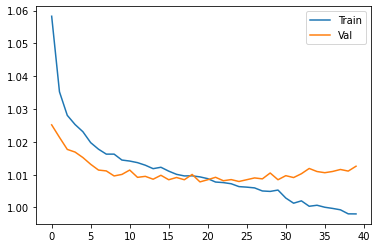

In [26]:
plt.plot(h.history['loss'], label='Train')
plt.plot(h.history['val_loss'], label='Val')
plt.legend()

The validiation log-loss of our model is around 1.01 and the accuracy is around 50%. Considered the bookmakers' model given by the competition holder is around 0.99, we think this is a reasonable result but still have a chance to improve. 

#### Future work

1.   Solve the overfitting problem.
2.   Try other models, such as GRU and Transformers.
3.   More features can be manipulated or created to increase the accurancy of our prediction.

#### **Reference**
[1] Football Match Probability Prediction | Kaggle (www.kaggle.com/competitions/football-match-probability-prediction/overview) \
[2] Emmanuel, T., Maupong, T., Mpoeleng, D. et al (2021). A survey on missing data in machine learning. J Big Data 8, 140 \
[3] D. Prasetio and D. Harlili (2016). Predicting football match results with logistic regression International Conference On Advanced Informatics: Concepts, Theory And Application,  1-5  \
[4] Rahul Baboota, Harleen Kaur (2019). Predictive analysis and modelling football results using machine learning approach for English Premier League, International Journal of Forecasting, 35(2), 741-755 \
[5] K. Huang and W. Chang (2010). A neural network method for prediction of 2006 World Cup Football Game The 2010 International Joint Conference on Neural Networks, 1-8. \
[6] lfredo, Y.F., & Isa, S.M. (2019). Football Match Prediction with Tree Based Model Classification. International Journal of Intelligent Systems and Applications. \
[7] Qiyun Zhang, Xuyun Zhang et al. (2021). Sports match prediction model for training and exercise using attention-based LSTM network, Digital Communications and Networks\
[8] https://en.wikipedia.org/wiki/Long_short-term_memory \
[9] Mohammed Alhamid. LSTM and Bidirectional LSTM for Regression \
[10] http://dprogrammer.org/rnn-lstm-gru